# Metrics III: GMM and SMM
## Homework 1
Chengzi Yi, 04/02/2022


This code is a sample code prepared for homework 1 of Metrics III/GMM&SMM
taught by Prof. Russell Cooper at the EUI.
I used pieces of code from Quantecon to illustrate Tauchen Method.

If you have any comments or suggestions, please contact Chengzi.Yi@eui.eu.


In [18]:
import numpy as np
import scipy as sp
from scipy import optimize
from quantecon.optimize.scalar_maximization import brent_max
import matplotlib.pyplot as plt
from numba import typeof, jit, njit, objmode, prange
from interpolation import interp



In [19]:
# helper function
@njit
def tauchen(rho, sigma_u, b=0., m=3, n=7):

    r"""
    This function is taken from quantecon,
    see 'https://quanteconpy.readthedocs.io/en/latest
    /markov/approximation.html#tauchen'

    Computes a Markov chain associated with a discretized version of
    the linear Gaussian AR(1) process

    .. math::

        y_{t+1} = b + \rho y_t + u_{t+1}

    using Tauchen's method. Here :math:`{u_t}` is an i.i.d. Gaussian process
    with zero mean.

    Parameters
    ----------
    b : scalar(float)
        The constant term of {y_t}
    rho : scalar(float)
        The autocorrelation coefficient
    sigma_u : scalar(float)
        The standard deviation of the random process
    m : scalar(int), optional(default=3)
        The number of standard deviations to approximate out to
    n : scalar(int), optional(default=7)
        The number of states to use in the approximation

    Returns
    -------

    the transition matrix and state values

    """

    # standard deviation of demeaned y_t
    std_y = np.sqrt(sigma_u**2 / (1 - rho**2))

    # top of discrete state space for demeaned y_t
    x_max = m * std_y

    # bottom of discrete state space for demeaned y_t
    x_min = -x_max

    # discretized state space for demeaned y_t
    x = np.linspace(x_min, x_max, n)

    step = (x_max - x_min) / (n - 1)
    half_step = 0.5 * step
    P = np.empty((n, n))

    # approximate Markov transition matrix for
    # demeaned y_t
    _fill_tauchen(x, P, n, rho, sigma_u, half_step)

    # shifts the state values by the long run mean of y_t
    mu = b / (1 - rho)
    x = mu + x

    return x, P

from math import erfc, sqrt
@njit
def std_norm_cdf(x):
    return 0.5 * erfc(-x / sqrt(2))

@njit
def _fill_tauchen(x, P, n, rho, sigma, half_step):
    for i in range(n):
        P[i, 0] = std_norm_cdf((x[0] - rho * x[i] + half_step) / sigma)
        P[i, n - 1] = 1 - \
            std_norm_cdf((x[n - 1] - rho * x[i] - half_step) / sigma)
        for j in range(1, n - 1):
            z = x[j] - rho * x[i]
            P[i, j] = (std_norm_cdf((z + half_step) / sigma) -
                       std_norm_cdf((z - half_step) / sigma))


## 1. Solution


In [20]:
@njit
def T(q, β):
    """
    rhs of the functional equation.

    * q: previous guess of q(d), vector of size ndd×1
    * β: discount factor

    - * d_grid: discretized state space of d
    - * Pd: transition matrix of d process
    """
    Tq = np.empty_like(q)
    for i in range(ndd):
        Tq[i] = d_grid[i] + β * (Pd[i,:] @ q)
    #Tq = d_grid + β * (Pd @ q)
    
    return Tq

@njit
def qfunc(q0, β, tol=1e-6, max_iter=1000):
    """
    iterate on the rhs until q converges.

    * q0: initial guess of q function
    """
    q = q0
    error = 1
    it = 0
    while error > tol and it < max_iter:
        q_new = T(q, β)
        error = np.max(np.abs(q_new - q))
        q = q_new
        it += 1
    #if it == max_iter:
    #    print(f"Fail to converge within {max_iter} iterations.")
    #elif it < max_iter and show_it is True:
    #    print(f"Converged in {it} iterations.")
    return q_new


Text(0, 0.5, '$q(d)$')

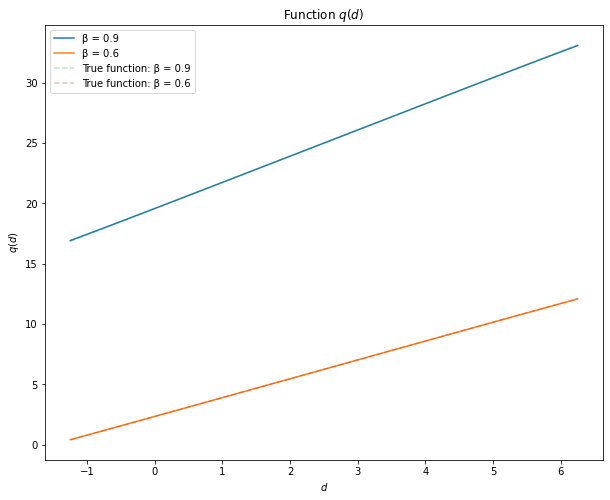

In [21]:
# process for dividends
ndd = 20
ρ_d = 0.6
σ_d = 1
b_d = 1
μ_d = 1 / (1 - ρ_d)
d_grid, Pd = tauchen(ρ_d, σ_d, b_d, n=ndd)

# solve q(d)
q0 = np.zeros_like(d_grid)
β1 = 0.9
β2 = 0.6
q_1 = qfunc(q0, β1)
q_2 = qfunc(q0, β2)

# true function q(d)
q_true = lambda d, β: (β / (1 - β)) * (1 / (1 - β * ρ_d)) * (1 - ρ_d) * (1 / (1 - ρ_d)) \
                         + 1 / (1 - β * ρ_d) * d

# plot
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(d_grid, q_1, label=f'β = {β1}')
ax.plot(d_grid, q_2, label=f'β = {β2}')
ax.plot(d_grid, q_true(d_grid, β1), label=f'True function: β = {β1}', ls = '--', alpha=0.3)
ax.plot(d_grid, q_true(d_grid, β2), label=f'True function: β = {β2}', ls = '--', alpha=0.3)
ax.legend()
ax.set_title("Function $q(d)$")
ax.set_xlabel("$d$")
ax.set_ylabel("$q(d)$")
#fig.savefig('Ex1_q1.png')


## 2. Estimation


In [22]:
# simulate the data and get the data moments
@njit
def jitted_normal(N, seed, μ=0, σ=1):
    """
    ignore this function;
    just to circumvent the compilation problem.
    """
    with objmode(y="float64[::1]"):
        rng = np.random.default_rng(seed)
        y=rng.normal(loc=μ, scale=σ, size=N)
    return y

@njit
def sim_data(S, T, seed, ρ=0.6, b=1, σ=1):
    """
    assume the dividend process is as in (1),
    simulate the sequence of dividend d and price q(d) for T periods.
    here allows dividend to be continuous;
    another way is to simulate the discretized markov chain process.

    * T: sample size
    * S: number of simulations
    * seed: seed for the random generator

    return simulated dividend of T periods for S simulations
    """
    # fix the shocks for the S simulations
    # allow for some burning periods, here 20 periods
    #rng = np.random.default_rng(seed)
    #ϵ_array = rng.normal(loc=0, scale=σ, size=S*(T+20))
    ϵ_array = jitted_normal(S*(T+20), seed=seed, μ=0, σ=σ)
    ϵ_array = ϵ_array.reshape(S, (T+20))

    # simulate dividend S times
    d_data = np.empty((S, T+20+1))
    d_data[:,0] = 0
    for t in range(T+20):
        d_data[:,t+1] = b + ρ * d_data[:,t] + ϵ_array[:,t]
    d_data = d_data[:,-T:]

    return d_data


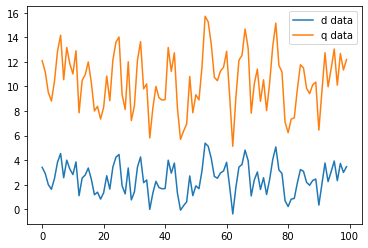

In [23]:
# "true data": number of simulations is S=1, sample size is T
β_star = 0.76
T_data = 100
d_data = sim_data(1, T_data, seed=3333)
q_data = q_true(d_data, β_star)
plt.plot(d_data.flatten(), label='d data')
plt.plot(q_data.flatten(), label='q data')
plt.legend()
# data moments
mm_dt = np.array([np.mean(q_data), np.var(q_data)])


In [24]:
def _sim_mc(S, T, P, d, seed):
    """
    simulate the discretized markov chain process.

    * T: sample size
    * S: number of simulations
    * seed: seed for the random generator
    * d: state values
    * P: transition matrix of discretized process

    return simulated data of T periods for S simulations, matrix of (S×T)
    """
    import quantecon.markov as markov
    mc = markov.core.MarkovChain(P, state_values=d)
    data_idx = mc.simulate_indices(T, init=None, num_reps=S, random_state=seed)
    data = d[data_idx]

    return data, data_idx

def sim_moments(β0, S, T, seed, full=False, use_data=False):
    """
    get simulated moments given guess of β.

    * β0: guess of β
    * S: number of simulations
    * T: sample size for simulated data
    """
    # simulate the dividend series
    d_sim, idx_sim = _sim_mc(S, T, Pd, d_grid, seed=seed)

    # solve the functional equation given β0
    q0 = np.zeros(ndd)
    q1 = qfunc(q0, β0)
    # given q(d), get the price series
    q_sim = q1[idx_sim]
    if use_data == True: #illustration on interpolation
        #interpolate to get continuous q(d) function
        q_f = lambda d: interp(d_grid, q1, d)
        q_sim = q_f(d_data.flatten()).reshape(S,T)
    # get the simulated moments for each simulation
    q_mean = np.mean(q_sim, axis=1)
    q_var = np.var(q_sim, axis=1)

    if full == True: # return the simulated data and the simulated moments for all simulations
        return q_sim, q_mean, q_var
    else: # return the average simulated moments
        return np.array([np.mean(q_mean), np.mean(q_var)])

def Jfunc(β0, W, S, T, seed=7777):
    """
    criterion function that need to be minimized.
    set seed, so for each guess of β, we are using the same simulated shock.

    * W: weighting matrix
    """
    mm_sim = sim_moments(β0, S, T, seed=seed)

    return (mm_sim - mm_dt) @ W @ (mm_sim - mm_dt)


The estimate of β with I being the weighting matrix is 0.7596


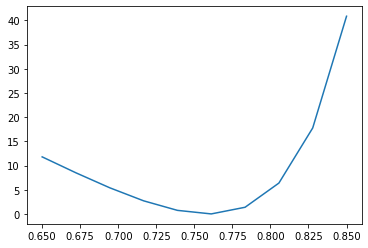

In [25]:
# use idendity matrix
I_mat = np.eye(2)
S_sim = 1
T_sim = 10_000
# minimizaiton with bounded method
opt={'maxiter': 10_00, 'disp': False}
res = optimize.minimize_scalar(Jfunc, args=(I_mat, S_sim, T_sim), bounds=(1e-9,1),
                    method='bounded', options=opt)
β_hat1 = res.x
print(f"The estimate of β with I being the weighting matrix is {β_hat1:.4f}")

# plot the criterion function
β_array = np.linspace(0.65, 0.85, 10)
J_array = np.empty_like(β_array)
for i, β in enumerate(β_array):
    J_array[i] = Jfunc(β, I_mat, S_sim, T_sim)
plt.plot(β_array, J_array)



In [26]:
def boot(N_sample, T_sample, data, seed):
    """
    obtain VCV of sample moments by bootstrap.

    * N_sample: number of sample
    * T_sample: length of sample, should be the same with the data period
    * data: either real data or simulated data;
              if simulated data, shape is (1×T̂), if real data, shape is (1×T)
    """
    T_hat = data.size
    total = N_sample * T_sample #total number of draws
    sample_idx = np.random.default_rng(seed).random(total) * T_hat
    sample_idx = sample_idx.astype(int)
    sample_idx = sample_idx.reshape((N_sample, T_sample))
    mm_sample = np.empty((N_sample, 2)) #column is different moment
    for n in range(N_sample):
        sample = data.flatten()[sample_idx[n,:]]
        mm_sample[n,:] = np.array([np.mean(sample), np.var(sample)])
    return np.cov(mm_sample, rowvar=False)

# obtain an estimate of better weighting matrix
q_sim = sim_moments(β_hat1, 1, T_sim, seed=3333, full=True)[0]
Ω1 = boot(500, T_data, q_data, 1133)
Ω2 = boot(500, T_data, q_sim, 3456)
W1 = np.linalg.inv(Ω2)
res_new = optimize.minimize_scalar(Jfunc, args=(W1, S_sim, T_sim), bounds=(0.6,0.9),
                    method='bounded', options=opt)
print(f"The estimate of β with Ŵ being the weighting matrix is {res_new.x:.4f}")


The estimate of β with Ŵ being the weighting matrix is 0.7593


In [27]:
import seaborn as sns
def plot_estimates(S, T, axe, W=I_mat, nss=200, fix_range=True, return_est=False):
    """
    get the distribution of β̂.

    * S: number of simulations
    * T: sample size
    * W: weighting matrix
    * nss: number of monte carlo draws
    """
    β_hat = np.empty(nss)
    rng = np.random.default_rng(seed=67)
    int = rng.integers(0, high=1000, size=nss)
    for i in range(nss):
        # change seed for each itereation
        res = optimize.minimize_scalar(Jfunc, args=(W, S, T, int[i]), bounds=(0.6,0.9),
                            method='bounded', options={'maxiter': 10_00, 'disp': False})
        β_hat[i] = res.x

    if fix_range == True:
        axe = sns.histplot(β_hat, stat='probability', kde=True, bins=25, binrange=(0.73,0.78),
                    alpha=0.5, color='0.6', ax=axe)
    elif fix_range == False:
        axe = sns.histplot(β_hat, stat='probability', kde=True, bins=25,
                    alpha=0.5, color='0.6', ax=axe)

    axe.axvline(x=β_star, ymax=0.95, linestyle='--', color='r', label='true $\\beta$')
    axe.axvline(x=np.mean(β_hat), ymax=0.95, linestyle='--', color='blue', label='$\\bar{\\hat{\\beta}}$')
    axe.set_title(f'S = {S} and T̂ = {T}')
    axe.legend()
    if return_est==True:
        return β_hat


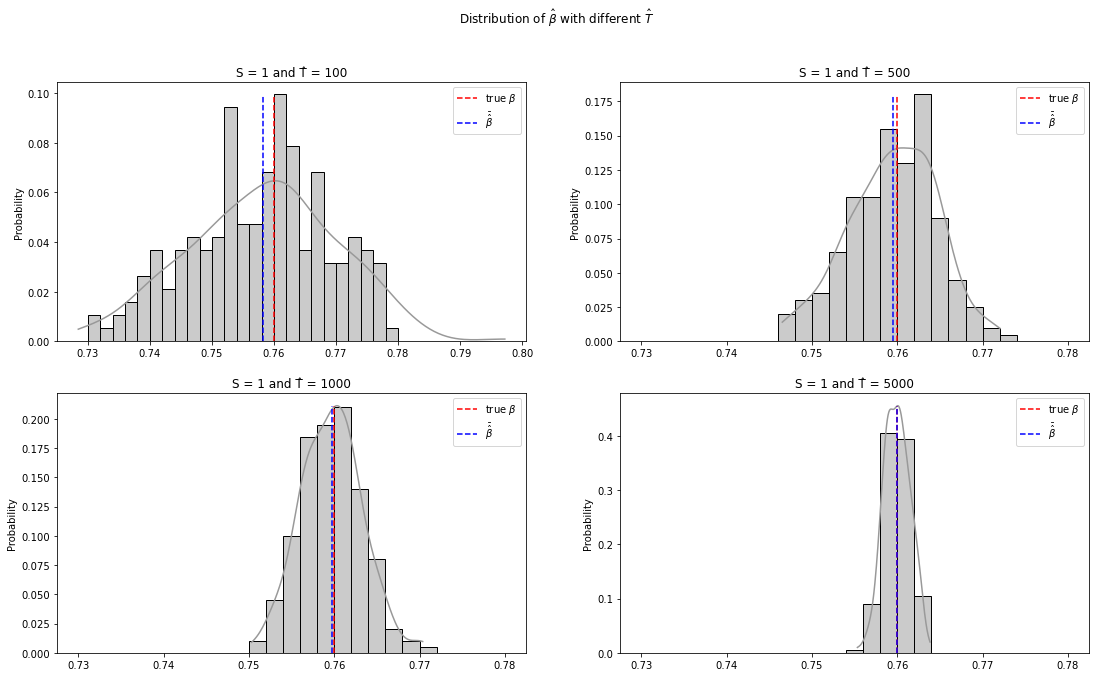

In [28]:
# how the distribution depends on T̂?
fig_e1, axes_e1 = plt.subplots(2, 2, figsize=(18.5,10.5))
fig_e1.suptitle('Distribution of $\hat{β}$ with different $\hat{T}$')
plot_estimates(1, 100, axes_e1[0,0])
plot_estimates(1, 500, axes_e1[0,1])
plot_estimates(1, 1000, axes_e1[1,0])
plot_estimates(1, 5000, axes_e1[1,1])


In [29]:
# how the distribution depends on S?
fig_e2, axes_e2 = plt.subplots(2, 2, figsize=(18.5,10.5))
fig_e2.suptitle('Distribution of $\hat{β}$ with different S')

plot_estimates(10, 100, axes_e2[0,0])
plot_estimates(100, 100, axes_e2[0,1])
plot_estimates(200, 100, axes_e2[1,0])
plot_estimates(500, 100, axes_e2[1,1])


Text(0.5, 1.0, 'Ŵ as Weighting Matrix; sd(β̂)=0.0106')

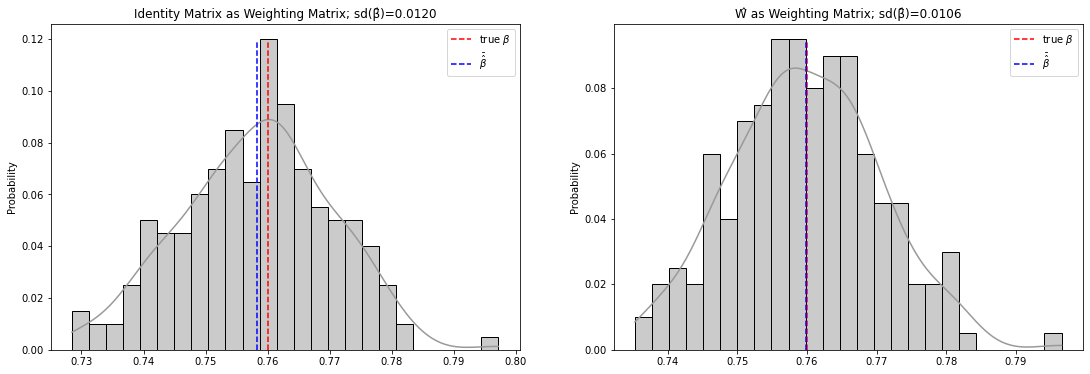

In [30]:
# how the distribution depends on W?
fig_e3, axes_e3 = plt.subplots(1, 2, figsize=(18.5,6))

β_I = plot_estimates(1, 100, axes_e3[0], W=I_mat, fix_range=False, return_est=True)
β_W = plot_estimates(1, 100, axes_e3[1], W=W1, fix_range=False, return_est=True)
axes_e3[0].set_title(f"Identity Matrix as Weighting Matrix; sd(β̂)={np.std(β_I):.4f}")
axes_e3[1].set_title(f"Ŵ as Weighting Matrix; sd(β̂)={np.std(β_W):.4f}")